## Modeling (BERT + CNN)
In this data challene, I use BERT and Kim's CNN for modeling. BERT (Bidirectional Encoder Representations from Transformers) is transformer based algorithm from Google in 2018. Unlike traditional context-free models, BERT can understand the different meaning of words in various contexts.  

I used a pretrained base BERT. Transfer learning using pretrained model can reduce training time significantly and can get good result only with limited source of data. Since my desktop's performance is limited, and I cannot spend too much time for this challenge, the pretrainde model is the best option.  

I attached the Kim's CNN architecture (2014) on the BERT embedding. CNN (Convolutional Neural Network) is the most popular deep learning algorithm for image data since it capture temporal and spatial dependencies better than Feed-Forward models. Because of this property, I tried Yoon Kim's CNN model in this project and it significantly increased the result (from 0.2 to 0.7 in F1 score on a validation set).

In [1]:
# # necessary packages
# !pip install tensorflow==2.0
# !pip install tensorflow_hub
# !pip install bert-for-tf2
# !pip install sentencepiece

# import the necessary packages
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras import regularizers
import tensorflow_addons as tfa

import csv
import pandas as pd
import numpy as np

import bert
FullTokenizer = bert.bert_tokenization.FullTokenizer

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/1", trainable=False)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

# file pathes
tr_un_sam_path = '../data/train_undersampled.csv'
val_un_sam_path = '../data/val_undersampled.csv'
test_path = '../data/test.csv'

# bert input length
max_seq_length = 128

# train batch size
batch = 128

# number of CNN filters
num_filters = 256

In [2]:
def file_length(path, option=None):
    '''
    calculate file length
    
    1. option = 'positive':
    return file length, positive number in over_18
    2. else:
    return file length
    '''
    with open(path, 'r', encoding='UTF-8', newline='') as csvfile:
        f = csv.DictReader(csvfile)
        length = 0
        pos = 0
        for line in f:
            length += 1
            if line['over_18'] == '1':
                pos += 1
    
    if option == 'positive':
        return length, pos
    
    else:
        return length

In [3]:
# bert preprocessing.
# https://colab.research.google.com/drive/1hMLd5-r82FrnFnBub-B-fVW78Px4KPX1

def get_masks(tokens, max_seq_length):
    """Mask for padding"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    return np.array([1]*len(tokens) + [0] * (max_seq_length - len(tokens)))


def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return np.array(segments + [0] * (max_seq_length - len(tokens)))


def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return np.array(input_ids)


def bert_preprocessing(string):
    tokens = tokenizer.tokenize(string)
    tokens = ["[CLS]"] + tokens + ["[SEP]"]

    input_ids = get_ids(tokens, tokenizer, max_seq_length)
    input_masks = get_masks(tokens, max_seq_length)
    input_segments = get_segments(tokens, max_seq_length)
    
    return input_ids, input_masks, input_segments

In [4]:
# batch generator. Edited codes from
# https://medium.com/analytics-vidhya/train-keras-model-with-large-dataset-batch-training-6b3099fdf366

def batch_generator(path, batch_size=1, steps=100):
    idx=0
    while True: 
        if idx<steps:
            idx+=1
        else:
            idx=1
        
        yield load_process_data(path,idx-1,batch_size)## Yields data

def load_process_data(path, idx, batch_size):
    df = pd.read_csv(path, skiprows=range(1, idx*batch_size), nrows=batch_size)
    df.dropna(inplace=True)
    x = df.iloc[:,1:]
    x['up_votes'] = x['up_votes']/10000
    x['year'] = x['year']/2016
    x['month'] = x['month']/12
    x['day'] = x['day']/31
    x['weekday'] = x['weekday']/7
    x['hour'] = x['hour']/24
    x['title'] = x['title'].apply(bert_preprocessing)
    x[['input_ids', 'input_masks', 'input_segments']] = pd.DataFrame(x['title'].tolist(), index=x.index)
    del x['title'], x['category']
    y = df.iloc[:,0]
    return [np.array(x.iloc[:,:6]), np.array(x.iloc[:,6]), np.stack(x.iloc[:,7], axis=0), 
            np.stack(x.iloc[:,8], axis=0), np.stack(x.iloc[:,9], axis=0)], np.array(y)

In [5]:
# define metrics

def precision(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tp_fp = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = tp / (tp_fp + K.epsilon())
    return precision

def recall(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tp_fn = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = tp / (tp_fn + K.epsilon())
    return recall

def f1(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tp_fp = K.sum(K.round(K.clip(y_pred, 0, 1)))
    tp_fn = K.sum(K.round(K.clip(y_true, 0, 1)))
    precision = tp / (tp_fp + K.epsilon())
    recall = tp / (tp_fn + K.epsilon())
    f1 = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1

In [6]:
tr_len, tr_pos_len = file_length(tr_un_sam_path, 'positive')
val_len = file_length(val_un_sam_path)
test_len = file_length(test_path)

tr_iter = tr_len//batch + 1
val_iter = val_len//batch + 1
test_iter = test_len//batch + 1

weight_for_0 = (1 / (tr_len-tr_pos_len))*(tr_len)/2.0
weight_for_1 = (1 / tr_pos_len)*(tr_len)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
print(class_weight)

{0: 0.5284591194968553, 1: 9.28453038674033}


In [12]:
# define input shapes
input_numeric = tf.keras.layers.Input(shape=(6,), dtype=tf.int32,
                                    name='input_numeric')
input_categorical = tf.keras.layers.Input(shape=(1,), dtype=tf.int32,
                                    name='input_category')
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

#bert sequence embedding
bert_emb = bert_layer([input_word_ids, input_mask, segment_ids])[1]
bert_emb = tf.reshape(bert_emb, [-1, max_seq_length, 768, 1])

#
xavier_initializer = tf.keras.initializers.GlorotNormal(seed=777)

# It is Kim's CNN. I added batch nomailization, activation, and dropout
conv_0 = Conv2D(num_filters, kernel_size=(3, 768), activation='relu', 
                kernel_regularizer=regularizers.l1_l2(l1=0.03, l2=0.1), kernel_initializer=xavier_initializer)(bert_emb)
conv_1 = Conv2D(num_filters, kernel_size=(5, 768), activation='relu', 
                kernel_regularizer=regularizers.l1_l2(l1=0.03, l2=0.1), kernel_initializer=xavier_initializer)(bert_emb)
conv_2 = Conv2D(num_filters, kernel_size=(7, 768), activation='relu', 
                kernel_regularizer=regularizers.l1_l2(l1=0.03, l2=0.1), kernel_initializer=xavier_initializer)(bert_emb)

maxpool_0 = MaxPool2D(pool_size=(max_seq_length - 3 + 1, 1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(max_seq_length - 5 + 1, 1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(max_seq_length - 7 + 1, 1), padding='valid')(conv_2)

conv_concat = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
flatten = Flatten()(conv_concat)
flatten = BatchNormalization()(flatten)
flatten = Activation('relu')(flatten)
flatten = Dropout(0.3)(flatten)

# numeric inputs
x = input_numeric
x = Dense(6, kernel_initializer=xavier_initializer)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# categorical inputs
y = input_categorical
y = tf.keras.layers.Embedding(len(word2id), 50)(y)
y = Flatten()(y)

concated = concatenate([x, y, flatten])
concated = Dense(128, kernel_regularizer=regularizers.l1_l2(l1=0.1, l2=0.1), 
                 kernel_initializer=xavier_initializer)(concated)
concated = BatchNormalization()(concated)
concated = Activation('relu')(concated)
concated = Dropout(0.3)(concated)
concated = Dense(16, kernel_regularizer=regularizers.l1_l2(l1=0.1, l2=0.1), 
                 kernel_initializer=xavier_initializer)(concated)
concated = BatchNormalization()(concated)
concated = Activation('relu')(concated)
concated = Dropout(0.2)(concated)
output = Dense(1, activation='sigmoid')(concated)

adam = Adam(lr=1e-3)
model = tf.keras.models.Model(inputs=[input_numeric, input_categorical, input_word_ids, input_mask, segment_ids], outputs=output)
model.compile(loss = 'binary_crossentropy',
              metrics=['accuracy', recall, f1], 
              optimizer=adam)

checkpoint = ModelCheckpoint('../models/best_model.hdf5', monitor='val_loss', save_best_only=True, period=1)
earlystopping = EarlyStopping(min_delta=1e-3, patience=10)
reduce_lr = ReduceLROnPlateau(factor=0.3, patience=1, min_delta=1e-3)

In [13]:
# train the model
print("[INFO] training model...")
history = model.fit_generator(
            batch_generator(tr_un_sam_path, batch, tr_iter),
            steps_per_epoch = tr_iter,
            validation_data = batch_generator(val_un_sam_path, batch, val_iter),
            validation_steps = val_iter,
            class_weight = class_weight,
            verbose = 2,
            callbacks = [checkpoint, earlystopping, reduce_lr],
            epochs=200)

[INFO] training model...
  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 27 steps, validate for 10 steps
Epoch 1/200
27/27 - 64s - loss: 377.7908 - accuracy: 0.7742 - recall: 0.5820 - f1: 0.2183 - val_loss: 254.1276 - val_accuracy: 0.8077 - val_recall: 0.5725 - val_f1: 0.2321
Epoch 2/200
27/27 - 58s - loss: 179.3136 - accuracy: 0.7719 - recall: 0.6853 - f1: 0.2473 - val_loss: 121.5267 - val_accuracy: 0.9391 - val_recall: 0.1769 - val_f1: 0.2052
Epoch 3/200
27/27 - 58s - loss: 88.2863 - accuracy: 0.7609 - recall: 0.6617 - f1: 0.2329 - val_loss: 69.1055 - val_accuracy: 0.9451 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 4/200
27/27 - 58s - loss: 52.3682 - accuracy: 0.7841 - recall: 0.7069 - f1: 0.2622 - val_loss: 47.5299 - val_accuracy: 0.9451 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 5/200
27/27 - 58s - loss: 40.1953 - accuracy: 0.7519 - recall: 0.6852 - f1: 0.2317 - val_loss: 40.5343 - val_accuracy: 0.9451 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 6/200
27/27 - 58s - loss: 35.0546 - accuracy: 0.7421 - recall: 0.7358 - f1

Epoch 49/200
27/27 - 58s - loss: 0.4753 - accuracy: 0.8920 - recall: 0.9356 - f1: 0.4900 - val_loss: 0.5397 - val_accuracy: 0.8721 - val_recall: 0.7347 - val_f1: 0.3488
Epoch 50/200
27/27 - 58s - loss: 0.4754 - accuracy: 0.8882 - recall: 0.9194 - f1: 0.4894 - val_loss: 0.5340 - val_accuracy: 0.8712 - val_recall: 0.7347 - val_f1: 0.3475
Epoch 51/200
27/27 - 58s - loss: 0.4620 - accuracy: 0.8876 - recall: 0.9242 - f1: 0.4859 - val_loss: 0.5332 - val_accuracy: 0.8704 - val_recall: 0.7347 - val_f1: 0.3461
Epoch 52/200
27/27 - 58s - loss: 0.4674 - accuracy: 0.8968 - recall: 0.9242 - f1: 0.4950 - val_loss: 0.5316 - val_accuracy: 0.8687 - val_recall: 0.7347 - val_f1: 0.3436
Epoch 53/200
27/27 - 56s - loss: 0.4598 - accuracy: 0.8938 - recall: 0.9312 - f1: 0.4964 - val_loss: 0.5318 - val_accuracy: 0.8644 - val_recall: 0.7347 - val_f1: 0.3384
Epoch 54/200
27/27 - 58s - loss: 0.4649 - accuracy: 0.8989 - recall: 0.9303 - f1: 0.5040 - val_loss: 0.5313 - val_accuracy: 0.8644 - val_recall: 0.7347 - v

The best model succeeds to tell more than 70% of over_18 on validation set. F1 score is much lower than recall since it has a lot of false positives. I tried a focal loss to solve this problem; however, it generated worse recall scores than the weighted binary crossentropy and higher score in F1 (both around 0.5). Choosing which one is better is depending on the model's purpose and I choose the higher recall score for this challge. The following charts show that loss and metrics for each iteration.

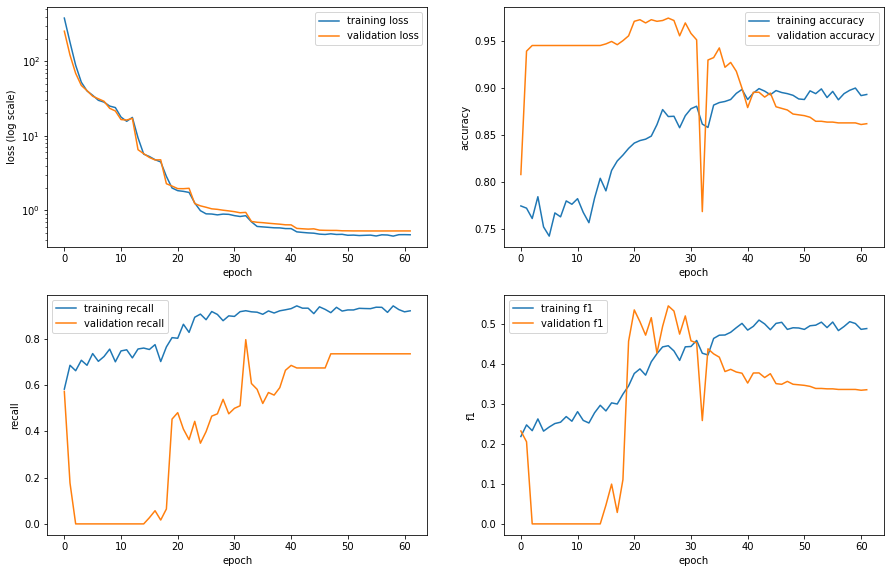

In [15]:
import matplotlib.pyplot as plt
epoch = len(history.history['loss'])
plt.figure(figsize=(15,15))
plt.subplot(321)
plt.plot(range(epoch), history.history['loss'], label='training loss')
plt.plot(range(epoch), history.history['val_loss'], label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss (log scale)')
plt.yscale('log')
plt.legend()

plt.subplot(322)
plt.plot(range(epoch), history.history['accuracy'], label='training accuracy')
plt.plot(range(epoch), history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(323)
plt.plot(range(epoch), history.history['recall'], label='training recall')
plt.plot(range(epoch), history.history['val_recall'], label='validation recall')
plt.xlabel('epoch')
plt.ylabel('recall')
plt.legend()

plt.subplot(324)
plt.plot(range(epoch), history.history['f1'], label='training f1')
plt.plot(range(epoch), history.history['val_f1'], label='validation f1')
plt.xlabel('epoch')
plt.ylabel('f1')
plt.legend()

plt.show()

In [8]:
# load model
model = tf.keras.models.load_model('../models/best_model.hdf5', custom_objects={'KerasLayer':hub.KerasLayer,
                                                                         'recall':recall,
                                                                         'f1':f1})
# summarize model.
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [9]:
pred_test = model.predict_generator(
    batch_generator(test_path, batch, test_iter), 
    steps=test_iter)

Instructions for updating:
Please use Model.predict, which supports generators.


Instructions for updating:
Please use Model.predict, which supports generators.


In [10]:
true_test = np.zeros(len(pred_test))

for i, xy in enumerate(batch_generator(test_path, batch, test_iter)):
    true_test[i*batch:(i+1)*batch] = xy[1]
    if i == test_iter-1:
        break

In [11]:
pred_test_label = (pred_test.flatten() >= 0.5)*1

In [12]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
print('accuracy:', accuracy_score(true_test, pred_test_label))
print('recall:', recall_score(true_test, pred_test_label))
print('precision:', precision_score(true_test, pred_test_label))
print('f1:', f1_score(true_test, pred_test_label))

accuracy: 0.8642665276042231
recall: 0.72
precision: 0.0039051200462829044
f1: 0.007768107602675683


On the test set, it produce a similar rate of recall and accuracy. On the other hand, precision and f1 are way lower than the validation set since it includes more negative targets as the following heatmap graph.

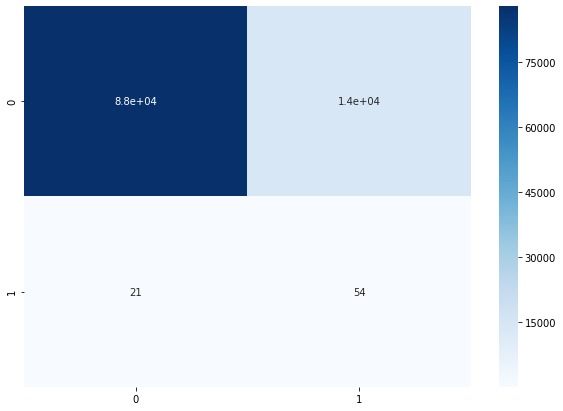

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (10,7))
sns.heatmap(confusion_matrix(true_test, pred_test_label), cmap=plt.cm.Blues, annot=True)
plt.show()